In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import gc
import time
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from time import gmtime, strftime

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score,KFold
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error

import scipy
import gc
import sys

#Add https://www.kaggle.com/anttip/wordbatch to your kernel Data Sources, 
#until Kaggle admins fix the wordbatch pip package installation
# sys.path.insert(0, '../input/wordbatch/wordbatch/')
##import wordbatch
##from wordbatch.extractors import WordBag, WordHash
##from wordbatch.models import FTRL, FM_FTRL

from nltk.corpus import stopwords
import re

def rmsle(y, y_pred):
     assert len(y) == len(y_pred)
     y = np.array(y)
     y_pred = np.array(y_pred)
     y_pred[y_pred<0] = 0
     y[y<0] = 0   
     
     return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y_pred), 2)))
    

In [4]:
NUM_BRANDS = 4500
NUM_CATEGORIES = 1250

develop = False
# develop= True

start_time = time.time()
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))

2018-02-02 13:11:37


In [5]:
LOAD_TEST = False
MAKE_SAMPLE = True

train = pd.read_table('input/train.tsv', engine='c')
if MAKE_SAMPLE:
    train = pd.read_table('input/train.tsv', engine='c')
    train = train.sample(n=50000).reset_index().drop('index',axis=1).copy(deep=True)
    
print('Train shape: ', train.shape)
merged = pd.concat([train])
nrow_train = train.shape[0]
del train


if LOAD_TEST:
    test = pd.read_table('input/test.tsv', engine='c')
    print('Test shape: ', test.shape)
    merged = pd.concat([merged, test])
    nrow_test = test.shape[0]
    del test
    
print('Merged shape: ', merged.shape)

merged.head()

Train shape:  (50000, 8)
Merged shape:  (50000, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,169422,Paris Decorative Box,2,Home/Home Décor/Home Décor Accents,Target,9.0,0,No description yet
1,12286,Nintendo DS Lite with 4 games,4,Electronics/Video Games & Consoles/Games,Nintendo,20.0,1,DS Lite missing pen and cable Comes with ULTIM...
2,516576,iPhone 6 Otterbox Defender Case,1,"Electronics/Cell Phones & Accessories/Cases, C...",NaN,24.0,0,Otter-box For 6 & 6S SO SORRY!!! But I am firm...
3,511311,IPad Mini 2,3,Electronics/Computers & Tablets/iPad/Tablet/eB...,Apple,31.0,0,In Good Condition Needs New Screen Message Me ...
4,430332,3t girls dresses,2,Kids/Girls 2T-5T/Dresses,NaN,8.0,1,3t short sleeve girls dresses. Both in excelle...


In [6]:
## preprocess - splitting category names
##

tt = pd.DataFrame([ str(x).split("/") for x in merged['category_name']])
cat_col_names = ['general_cat','subcat_1','subcat_2','subcat_3','subcat_4']
tt.columns = ['general_cat','subcat_1','subcat_2','subcat_3','subcat_4']

merged[cat_col_names] = tt
merged["category_name"] = merged["category_name"].fillna("Other").astype("category")

## merged.drop('category_name', axis=1, inplace=True)
del tt


In [7]:
## replace missing values
for col_name in  cat_col_names+['brand_name']+['item_description']:
    merged['mis_'+col_name] = 0
    merged[col_name].fillna(value='missing', inplace=True)
    merged.loc[merged[col_name]=='missing','mis_'+col_name] = 1

merged.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2,subcat_3,subcat_4,mis_general_cat,mis_subcat_1,mis_subcat_2,mis_subcat_3,mis_subcat_4,mis_brand_name,mis_item_description
0,169422,Paris Decorative Box,2,Home/Home Décor/Home Décor Accents,Target,9.0,0,No description yet,Home,Home Décor,Home Décor Accents,missing,missing,0,0,0,1,1,0,0
1,12286,Nintendo DS Lite with 4 games,4,Electronics/Video Games & Consoles/Games,Nintendo,20.0,1,DS Lite missing pen and cable Comes with ULTIM...,Electronics,Video Games & Consoles,Games,missing,missing,0,0,0,1,1,0,0
2,516576,iPhone 6 Otterbox Defender Case,1,"Electronics/Cell Phones & Accessories/Cases, C...",missing,24.0,0,Otter-box For 6 & 6S SO SORRY!!! But I am firm...,Electronics,Cell Phones & Accessories,"Cases, Covers & Skins",missing,missing,0,0,0,1,1,1,0
3,511311,IPad Mini 2,3,Electronics/Computers & Tablets/iPad/Tablet/eB...,Apple,31.0,0,In Good Condition Needs New Screen Message Me ...,Electronics,Computers & Tablets,iPad,Tablet,eBook Readers,0,0,0,0,0,0,0
4,430332,3t girls dresses,2,Kids/Girls 2T-5T/Dresses,missing,8.0,1,3t short sleeve girls dresses. Both in excelle...,Kids,Girls 2T-5T,Dresses,missing,missing,0,0,0,1,1,1,0


In [8]:
VAL_MISS_MARGIN = 10

### delete rare brands
##

pop_brand = merged['brand_name'].value_counts().loc[lambda x: x<=VAL_MISS_MARGIN].index.values
merged.loc[merged['brand_name'].isin(pop_brand), 'mis_brand_name'] = 1
merged.loc[merged['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'

## delete rare categories
##

pop_category1 = merged['general_cat'].value_counts().loc[lambda x: x<=VAL_MISS_MARGIN].index.values
pop_category2 = merged['subcat_1'].value_counts().loc[lambda x: x<=VAL_MISS_MARGIN].index.values
pop_category3 = merged['subcat_2'].value_counts().loc[lambda x: x<=VAL_MISS_MARGIN].index.values
# merged.loc[merged['general_cat'].isin(pop_brand), 'mis_general_cat'] = 1
# merged.loc[merged['general_cat'].isin(pop_category1), 'general_cat'] = 'missing'
# merged.loc[merged['subcat_1'].isin(pop_brand), 'mis_subcat_1'] = 1
# merged.loc[merged['subcat_1'].isin(pop_category2), 'subcat_1'] = 'missing'
# merged.loc[merged['subcat_2'].isin(pop_brand), 'mis_subcat_2'] = 1
# merged.loc[merged['subcat_2'].isin(pop_category3), 'subcat_2'] = 'missing'
    
print (pop_brand)
print (len(pop_category1),pop_category1[1:5])
print (len(pop_category2),pop_category2[1:5])
print (len(pop_category3),pop_category3[1:5])

['Nerf' 'Cherokee' 'tokidoki' ..., 'B. Darlin' 'Shock Doctor' 'Matty M']
0 []
18 ['Safety' 'Patterns' 'Magazines' 'Crochet']
317 ['Swings, Jumpers & Bouncers' 'Duvet Covers & Sets'
 'Stationery & Party Supplies' 'Turtleneck, Mock']


In [9]:
## https://www.kaggle.com/anttip/wordbatch-ftrl-fm-lgb-lbl-0-42555/code
## https://www.kaggle.com/anttip/wordbatch-ftrl-fm-lgb-lbl-0-42555/code
merged.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2,subcat_3,subcat_4,mis_general_cat,mis_subcat_1,mis_subcat_2,mis_subcat_3,mis_subcat_4,mis_brand_name,mis_item_description
0,169422,Paris Decorative Box,2,Home/Home Décor/Home Décor Accents,Target,9.0,0,No description yet,Home,Home Décor,Home Décor Accents,missing,missing,0,0,0,1,1,0,0
1,12286,Nintendo DS Lite with 4 games,4,Electronics/Video Games & Consoles/Games,Nintendo,20.0,1,DS Lite missing pen and cable Comes with ULTIM...,Electronics,Video Games & Consoles,Games,missing,missing,0,0,0,1,1,0,0
2,516576,iPhone 6 Otterbox Defender Case,1,"Electronics/Cell Phones & Accessories/Cases, C...",missing,24.0,0,Otter-box For 6 & 6S SO SORRY!!! But I am firm...,Electronics,Cell Phones & Accessories,"Cases, Covers & Skins",missing,missing,0,0,0,1,1,1,0
3,511311,IPad Mini 2,3,Electronics/Computers & Tablets/iPad/Tablet/eB...,Apple,31.0,0,In Good Condition Needs New Screen Message Me ...,Electronics,Computers & Tablets,iPad,Tablet,eBook Readers,0,0,0,0,0,0,0
4,430332,3t girls dresses,2,Kids/Girls 2T-5T/Dresses,missing,8.0,1,3t short sleeve girls dresses. Both in excelle...,Kids,Girls 2T-5T,Dresses,missing,missing,0,0,0,1,1,1,0


In [10]:
NAME_MIN_DF = 10 ## lower bound for word count
MAX_FEAT_DESCP = 5000

print("Encodings")

count = CountVectorizer(min_df=NAME_MIN_DF)
X_name = count.fit_transform(merged["name"])
X_name

print("Category Encoders")
count_category = CountVectorizer()
X_category = count_category.fit_transform(merged["category_name"])

print("Descp encoders")
count_descp = TfidfVectorizer(max_features = MAX_FEAT_DESCP, 
                              ngram_range = (1,3),
                              stop_words = "english")
X_descp = count_descp.fit_transform(merged["item_description"])

print("Brand encoders")
vect_brand = LabelBinarizer(sparse_output=True)
X_brand = vect_brand.fit_transform(merged["brand_name"])

print("Dummy Encoders")
merged['item_condition_id'] = merged['item_condition_id'].astype('category')
merged['shipping'] = merged['shipping'].astype('category')
X_dummies = scipy.sparse.csr_matrix(pd.get_dummies(merged[["item_condition_id", "shipping"]], sparse = True).values)



Encodings
Category Encoders
Descp encoders
Brand encoders
Dummy Encoders


In [11]:
X = scipy.sparse.hstack((X_dummies, 
                         X_descp,
                         X_brand,
                         X_category,
                         X_name)).tocsr()
del X_dummies, X_descp, X_brand,X_category,X_name
gc.collect()

149

In [49]:
 merged.loc[merged['price']<3,'price'] = 3

In [51]:
y_merged_train = merged['price'][:nrow_train]
y_merged_train = np.log1p(y_merged_train)
X_merged_train = X[:nrow_train]

X_train, X_valid, y_train, y_valid = train_test_split(X_merged_train, y_merged_train, test_size=0.2)
k_fold = KFold(n_splits=5,random_state=101)


print (X_train.shape, len(y_train))
print (X_valid.shape, len(y_valid))


(40000, 8737) 40000
(10000, 8737) 10000


In [52]:
## https://www.kaggle.com/apapiu/ridge-script
##

## scorer_func = make_scorer(rmsle,greater_is_better=False)
## scorer_func = make_scorer(r2_score,greater_is_better=True)
scorer_func = make_scorer(mean_squared_error,greater_is_better=False)
## scorer_func = make_scorer(mean_squared_log_error,greater_is_better=False)

mm = Ridge(solver = "lsqr", fit_intercept=False)

scores = cross_val_score(mm, X_train, y_train, 
                         cv=k_fold, n_jobs=-1,scoring = scorer_func)
print (scores)

## test on validation
mm.fit(X_train, y_train)
y_pred = mm.predict(X_valid)
y_pred[y_pred<1.386]=1.386

print ("RMSLE: ",rmsle(np.expm1(y_valid),np.expm1(y_pred)))
print ("RMSE: ",mean_squared_error(y_valid,y_pred))
print ("R2: ",r2_score(y_valid,y_pred))

[-0.2889151  -0.29802562 -0.2911706  -0.27831988 -0.29541377]
RMSLE:  0.532194548857
RMSE:  0.283231037833
R2:  0.485362300938


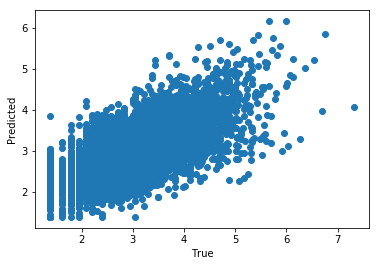

In [54]:
plt.scatter(y_valid,y_pred)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [25]:
min(y_valid[y_valid>0])

1.3862943611198906

In [42]:
params2 = {
        'learning_rate': 1,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 120,
        'verbosity': -1,
        'metric': 'RMSE',
        'data_random_seed': 2,
        'bagging_fraction': 1,
        'nthread': 4
}

d_train = lgb.Dataset(X_train, label=y_train)
d_valid = lgb.Dataset(X_valid, label=y_valid)


watchlist2 = [d_valid]    
model = lgb.train(params2, train_set=d_train, num_boost_round=8000, valid_sets=watchlist2, \
    early_stopping_rounds=250, verbose_eval=1000)     

y_pred = model.predict(X_valid)

y_pred[y_pred<0] = 0
print ("RMSLE: ",rmsle(y_valid,y_pred))
print ("RMSE: ",mean_squared_error(y_valid,y_pred))
print ("R2: ",r2_score(y_valid,y_pred))


Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[106]	valid_0's rmse: 0.588073
RMSLE:  0.147631713165
RMSE:  0.345829469307
R2:  0.406492131993


In [31]:
lgb.Dataset??

In [35]:
lgb.train??

In [43]:
lgb.train??